## Figure 2; Supplementary Figure 3A-C; Supplementary Table 3

Analysis for comparisons of PWM data generated from universal UV-Bind data. 


### Overview - Model alignment and trimming

PWM files generated from Seed-and-Wobble are processed and compared. The models are by default an arbitrary length and an arbitrary orientation. To directly compare models across Non-UV and UV conditions of the same trancription factor (TF) these need to be addressed. For each transcription factor:

1. A consensus sequence of the binding core is given to define a binding site. 
2. This sequence is scored across the PWM in both orientations. The top scoring position is considered the binding site. 
3. The submatrix for non-UV of the top scoring position is then compared to the UV matrix using KL divergence.
4. The position of minimum divergence is considered the aligned position between the two models. 
5. The models are then extended by 3 to account for flanking sequence.


### 3rd Party Packages

1. Logomaker - Plotting PWM logos
2. Matplotlib - Adjusting parameters for logomaker plots
3. Numpy - Array usage
4. Pandas - Dataframe usage
5. Scipy - KL Divergence

### UV Bind Analysis Core Imports

- uac.PYDI: Tuple of pyrimidine dinucleotides and their reverse complements

** Additional details can be found in the uvbind_analysis_core.py script.

### Abbreviations:

- pydi: Pyrimidine Dinucleotide
- df: DataFrame
- pdf: Probability DataFrame
- kl: Kullback–Leibler
- ic: Information Content
- dict: Dictionary
- pwm: Position Weight Matrix
- nuv: Non-UV

### Imports and Meta Data

In [1]:
# Imports
from __future__ import annotations
import os

from bokeh.io import export_svg
from bokeh.models import VBar
from bokeh.plotting import figure, ColumnDataSource
import logomaker
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import scipy.special
from scipy import stats
import seaborn as sns

import uvbind_analysis_core as uac


# Global Variables
# Input folders
DATA_FOLDER = "../../Data/PWM_Files"
META_DATA_FILE = "Meta_Data/Meta_Data_PWM_Comparisons.csv"
# Output folders
OUTPUT_FOLDER_F2 = "../Figure_2"
OUTPUT_FOLDER_SUPP = "../Figure_S3"
OUTPUT_FOLDER_T = "../Table_S3"
# Colors for PWM logos
LOGO_COLOR_SCHEME = {"A":(0, 0.8, 0), # R G B
                     "C":(0, 0, 0.8),
                     "G":(0.8, 0.8, 0.1),
                     "T":(0.8, 0, 0.1)}
# Color for PWM probability differences boxplot and bargraphs
# Color is UV conditions relative to non UV conditions
INCREASE_COLOR = "#8db0fe"
DECREASE_COLOR = "#f4987a"

In [2]:
for folder in (OUTPUT_FOLDER_F2, OUTPUT_FOLDER_SUPP, OUTPUT_FOLDER_T):
    os.makedirs(folder, exist_ok=True)

### Figure 2B-C; Supplementary Figure 3A: PWM trimming and alignment

PWM files generated from Seed-and-Wobble are processed and compared. The models are by default an arbitrary length and an arbitrary orientation. To directly compare models across Non-UV and UV conditions of the same trancription factor (TF) these need to be addressed. For each transcription factor:

1. A consensus sequence of the binding core is given to define a binding site. 
2. This sequence is scored across the PWM in both orientations. The top scoring position is considered the binding site. 
3. The submatrix for non-UV of the top scoring position is then compared to the UV matrix using KL divergence.
4. The position of minimum divergence is considered the aligned position between the two models. 
5. The models are then extended by 3 to account for flanking sequence.


#### (1) Functions:

In [3]:
def matrix_position(file_path: str, matrix_name: str) -> int:
    """Returns number of lines to skip for given matrix name

    :param file_path: Relative path to the PWM file
    :type file_path: str
    :param matrix_name: Name of the matrix (Probability, Enrichment, etc.)
    :type matrix_name: str
    :returns: Number of lines to skip when reading the file
    """
    # Parse file for matrix to read
    skip = -1
    file_object = open(file_path, 'r')
    for idx, line in enumerate(file_object):
        if line.startswith(matrix_name):
            skip = idx + 2
            break
    file_object.close()
    if skip == -1:
        raise ValueError(f"Cannot find {matrix_name} in file.")
    return skip


def read_pwm_matrix(file_path: str,
                    matrix_name: str = "Prob") -> pd.DataFrame:
    """Returns top PWM from a PWM Seed-and-Wobble output

    :param file_path: Relative path to the PWM file
    :type file_path: str
    :param skip: Number of rows to skip in reading the probability matrix
    :type skip: int
    :returns: PWM matrix in long form (columns = A, C, G, T)
    """
    skip = matrix_position(file_path, matrix_name)
    # Read matrix
    pwm = pd.read_csv(file_path,
                      sep='\t',
                      skiprows=skip,
                      header=None,
                      nrows=4)
    pwm = pwm[pwm.columns[1:]]
    pwm_long = pwm.T
    pwm_long = pwm_long.rename(columns={0: 'A', 1: 'C', 2: 'G', 3: 'T'})
    return pwm_long.reset_index(drop=True)


def reverse_complement_matrix(pwm_long: pd.DataFrame) -> pd.DataFrame:
    """Reverse complement of long form PWM matrix

    :param pwm_long: Long form PWM matrix
    :type pwm_long: pd.DataFrame
    :returns: Reverse complement of input matrix as a pd.Dataframe
    """
    pwm = pwm_long.iloc[::-1, :]
    pwm = pwm.reset_index(drop=True)
    pwm = pwm.rename(columns={'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'})
    pwm = pwm[['A', 'C', 'G', 'T']]
    return pwm


def plot_ic_matrix_logo(matrix: pd.DataFrame, ax, color_scheme) -> logomaker.Logo:
    """Save an information content logo from a long format matrix to output"""
    logo = logomaker.Logo(matrix,ax=ax, color_scheme=color_scheme)
    logo.style_spines(spines=["left", "bottom"], visible=True)
    # No tick marks or labels
    logo.ax.set_xticks([])
    logo.ax.set_yticks([])
    logo.ax.set_yticklabels([])
    # ylim is 0, 2 since the PWM information content ranges from 0 to 2
    logo.ax.set_ylim([0, 2])
    return logo


def max_scoring_position(kmer: str,
                         pwm: pd.DataFrame) -> tuple[int, float]:
    """Return the position of the max score and that score.

    Given a kmer and pwm in long format, finds the maximum
    scoring position of the kmer and returns a tuple of the
    position and score.
    """
    max_score = 0
    max_position = -1
    for i in range(len(pwm) - len(kmer) + 1):
        # Get score of local range
        subscore = 1
        for idx, j in enumerate(kmer):
            probability = pwm[j][i + idx]
            subscore *= probability
        if subscore > max_score:
            max_score = subscore
            max_position = i
    return (max_position, max_score)


def top_submatrix_from_kmer(kmer: str,
                            pwm: pd.DataFrame,
                            extend=3) -> pd.DataFrame:
    """Return the top scoring submatrix in either orientation from a kmer.
    
    Given a kmer, pwm in long format, and a parameter to extend the match,
    return a submatrix of the pwm that overlaps with the top scoring position
    of the kmer extended by the number of positions in the extend parameter if
    possible. Return a submatrix in long format.
    """
    orient_a = max_scoring_position(kmer, pwm)
    pwm_reverse_complement = reverse_complement_matrix(pwm)
    orient_b = max_scoring_position(kmer, pwm_reverse_complement)
    if orient_a[1] > orient_b[1]:
        orient = orient_a
        pwm_oriented = pwm
    else:
        orient = orient_b
        pwm_oriented = pwm_reverse_complement
    start = max(0, orient[0] - extend)
    end = min(len(pwm_oriented) - 1, orient[0] + len(kmer) + extend)
    return pwm_oriented.iloc[start:end, :].reset_index(drop=True)


def kl_divergence(p, q):
    """Kullback-Leibler divergence in bits"""
    return np.sum(np.where(p != 0, p * np.log2(p / q), 0))


def kl_divergence_sum(pwm_a: pd.DataFrame,
                      pwm_b: pd.DataFrame) -> float:
    """Returns the sum of divergences"""
    kl_sum = 0
    for i in range(len(pwm_a)):
        np_matrix_a = np.array(list(pwm_a.T[i]))
        np_matrix_b = np.array(list(pwm_b.T[i]))
        kl_sum += kl_divergence(np_matrix_a, np_matrix_b)
    return kl_sum


def min_kl_divergence_overlap(pwm_small: pd.DataFrame,
                              pwm_large: pd.DataFrame):
    """Position and value of the minimum KL divergence.
    
    Given a pwm of less than or equal length (pwm_small) and a larger or 
    equal size pwm, returns a tuple conainting the following:
    1. Position of minimal divergence
    2. Value of minimal divergence
    """
    best_match_position = -1
    best_match_distance = float('inf')
    for i in range(len(pwm_large) - len(pwm_small) + 1):
        start = i
        end = i + len(pwm_small)
        pwm_b = pwm_large.iloc[start:end, :].reset_index(drop=True)
        distance = kl_divergence_sum(pwm_small,
                                     pwm_b)
        if distance < best_match_distance:
            best_match_position = i
            best_match_distance = distance
    return (best_match_position, best_match_distance)


def best_match(pwm_a: pd.DataFrame,
               pwm_b: pd.DataFrame,
               consensus: str,
               extend: int = 3) -> pd.DataFrame:
    """Returns the pwm_b subset with the minimum KL divergence from pwm_a."""
    # Return the pwm_a subset of the top scoring overlap of the consensus sequence.
    pwm_query = top_submatrix_from_kmer(consensus, pwm_a, extend=0)
    pwm_b_reverse_complement = reverse_complement_matrix(pwm_b)
    # Compare both orientations of the subset and pick the one with the best match
    orient_a = min_kl_divergence_overlap(pwm_query, pwm_b)
    orient_b = min_kl_divergence_overlap(pwm_query,
                                         pwm_b_reverse_complement)
    if orient_a[1] < orient_b[1]:
        orient = orient_a
        pwm_oriented = pwm_b
    else:
        orient = orient_b
        pwm_oriented = pwm_b_reverse_complement
    # Based on the best match, return the subset of b in the best matching orientation
    start = max(0, orient[0] - extend)
    end = min(len(pwm_oriented) - 1, orient[0] + len(consensus) + extend)
    return pwm_oriented.iloc[start:end, :].reset_index(drop=True)




#### (2) Analysis:

The PWM files are drawn in a group of 2 figures, each containing a row of PWMs.

In [6]:
# Read meta data
full_meta_data = pd.read_csv(META_DATA_FILE)
ic_matrix_list = []
pwm_dict = {}
# For each row of PWM logos
for subplot, subplot_name in ((0, "Top_Row"), (1, "Bottom_Row")):
    meta_data = full_meta_data[full_meta_data["Subplot"] == subplot].reset_index(drop=True)
    # For each row, generate the plots specified
    fig, ax_array = plt.subplots(2, 5)
    fig.set_size_inches(40, 5)
    for row in meta_data.itertuples():
        # Read PWM files for non-UV and UV
        pwm_nuv = read_pwm_matrix(f"{DATA_FOLDER}/{row.Non_UV}_{row.File_Non_UV}")
        pwm_uv = read_pwm_matrix(f"{DATA_FOLDER}/{row.UV}_{row.File_UV}")
        # Trim the non-UV matrix based on the consensus site
        pwm_nuv = top_submatrix_from_kmer(row.Consensus, pwm_nuv)
        # Find best match to the UV matrix
        pwm_uv = best_match(pwm_nuv, pwm_uv, row.Consensus)
        # List of pairs to save
        pwm_list = []
        # Plot the logos
        for pwm, name, rn in zip((pwm_nuv, pwm_uv), (row.Non_UV, row.UV), (0, 1)):
            information_matrix = logomaker.transform_matrix(pwm,
                                                            from_type="probability",
                                                            to_type="information")
            logo = plot_ic_matrix_logo(information_matrix,
                                       ax=ax_array[rn][row.Figure_Column],
                                       color_scheme=LOGO_COLOR_SCHEME)
            information_matrix["Experiment"] = name
            ic_matrix_list.append(information_matrix)
            pwm_list.append(pwm)
        # Add PWM list pair to the dictionary as a tuple
        pwm_dict[row.Protein] = tuple(pwm_list)
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(fname=f"{OUTPUT_FOLDER_F2}/{subplot_name}.svg",format='svg')
    plt.savefig(fname=f"{OUTPUT_FOLDER_SUPP}/{subplot_name}.svg",format='svg')
    plt.close()
# Concatinate the raw plotted data for the logos and save
#ic_plotted_data = pd.concat(ic_matrix_list)
#ic_plotted_data = ic_plotted_data.reset_index()
#ic_plotted_data = ic_plotted_data.rename(columns={"pos":"Position"})
#ic_plotted_data["Experiment"] = ic_plotted_data["Experiment"].apply(lambda x: "_".join(x.split('_')[:2]))
#ic_plotted_data["Experiment"] = ic_plotted_data["Experiment"].apply(lambda x: x.replace("_WC", "_NonUV"))
#ic_plotted_data.to_csv(f"{OUTPUT_FOLDER_T}/Table_S3A.csv", index=False, float_format="%.6f")

### Supplementary Table 3A - PWM Probabilities

In [15]:
# Concatinate the PWM data as probabilities and save
s_table_3a = []
for protein in pwm_dict.copy():
    nuv, uv = pwm_dict[protein]
    nuv["Experiment"] = f"{protein}_NonUV"
    uv["Experiment"] = f"{protein}_UV"
    s_table_3a.append(nuv)
    s_table_3a.append(uv)
s_table_3a = pd.concat(s_table_3a).reset_index()
s_table_3a = s_table_3a.rename(columns={"index":"Position"})
s_table_3a.to_csv(f"{OUTPUT_FOLDER_T}/Table_S3A_PWM_Probabilities.csv", index=False, float_format="%.6f")

### Figure 2C, Supplementary Figure 3A; Pyrimidine dinucleotide formation probabilities

Given a sliding 2-bp window, calculate the probability of forming pyrimidine dinucleotides for PWMs of each transcription factor in non-UV and UV conditions. Then calculate the difference in the probability they form.

When assembling the figures, the position with the largest difference will be colored. The color is based on a diverging color palette from -1 to 1. 

#### (1) Functions:

In [6]:
def pydi_formation_probability(pwm: pd.DataFrame,
                               prefix: str,
                               pydi_tuples=uac.PYDI) -> pd.DataFrame:
    """Return probabilities for pyrimidine dinucelotide formation.

    Calculates the probability of any pyrimidine dinucleotide forming across a
    2-position sliding window for a PWM model. Returns a dataframe with the
    first position in the window and the probability.
    """
    # Create a list of probabilities at each 2-position window
    probabilities = []
    for i in range(len(pwm) - 1):
        # Sum probabilities for each pyrimidine dinucleotide
        any_pydi_probability = 0
        for left, right in map(tuple, pydi_tuples):
            any_pydi_probability += pwm[left][i] * pwm[right][i + 1]
        probabilities.append((i, any_pydi_probability))
    # Type cast the probabilities list into a dataframe
    df = pd.DataFrame(probabilities)
    df = df.rename(columns={0: "First_Position",
                            1: f"{prefix}_PyDi_Probability"})
    return df


def compare_pydi_formation(protein_name: str,
                           df_nuv: pd.DataFrame,
                           df_uv: pd.DataFrame) -> pd.DataFrame:
    """Calculate the difference in pydi formation for a pair of pwm models.

    Given a pwm model for non-UV and UV, determines the difference in the
    probability of pyrimidine dinucleotide formation. Return a dataframe with
    the differences between the two models. 
    """
    pdfa = pydi_formation_probability(df_nuv, "NUV")
    pdfb = pydi_formation_probability(df_uv, "UV")
    pdf = pd.merge(pdfa, pdfb, on="First_Position")
    pdf["NUV_minus_UV"] = pdf[pdf.columns[1]] - pdf[pdf.columns[2]]
    pdf["Absolute_Difference"] = abs(pdf["NUV_minus_UV"])
    pdf["Comparison"] = protein_name
    return pdf

def color_from_mpl_palette(palette: str,
                           query_value: float,
                           value_min: float,
                           value_max: float) -> str:
    """Return the hex color code from a matplotlib color palette.
    
    Given a query value, the value range the pallette is being used for, and 
    the name of the matplotlib palette, returns a hex color code as a string for
    the value.
    """
    # Color map object
    color_map = matplotlib.cm.get_cmap(palette)
    # Get normalization of values based on value range
    normalization = matplotlib.colors.Normalize(vmin=value_min, vmax=value_max)
    # Output includes rgb and luminence but only rgb is needed for hex code
    rgb_colors = color_map(normalization(query_value))[:3]
    color = matplotlib.colors.rgb2hex(rgb_colors)
    return color


#### (2) Analysis:

In [7]:
# Analysis
results = [compare_pydi_formation(
    x, pwm_dict[x][0], pwm_dict[x][1]) for x in pwm_dict]
pydi_probabilities = pd.concat(results).reset_index(drop=True)
# Add color information
pydi_probabilities["Plot_Position"] = pydi_probabilities["First_Position"] + 1
pydi_probabilities["Color_F2"] = pydi_probabilities["NUV_minus_UV"].apply(lambda x: color_from_mpl_palette("coolwarm", x, -1, 1))
pydi_probabilities["Color_F2S"] = pydi_probabilities["NUV_minus_UV"].apply(lambda x: DECREASE_COLOR if x >= 0 else INCREASE_COLOR)
di = {DECREASE_COLOR:"Decrease", INCREASE_COLOR:"Increase"}
pydi_probabilities["Group"] = pydi_probabilities["Color_F2S"].apply(lambda x: di[x])
# Save results
pydi_probabilities.to_csv(f"{OUTPUT_FOLDER_SUPP}/Table_Probability_Diff.csv", index=False)
# Find max absolute difference and save to table
max_differences = pydi_probabilities[["Comparison", "Absolute_Difference"]].groupby(by="Comparison").aggregate(np.max)
max_differences = max_differences.reset_index()
max_differences = max_differences.rename(columns={"Absolute_Difference":"Max_Absolute_Difference"})
max_differences.to_csv(f"{OUTPUT_FOLDER_F2}/Table_MaxAbsDiff.csv")
max_differences.to_csv(f"{OUTPUT_FOLDER_SUPP}/Table_MaxAbsDiff.csv")

### Supplementary Figure 3A: Comparison of pyrimidine dinucleotide formation probabilities

In figure 2, the largest change in pyrimidine dinucelotide formation was indicated with a highlighted position. For this figure, changes across the models are shown using a barplot above the PWM logos. The following code block generates a barplot for each transcription factor and saves it in svg format. 

In [8]:
for protein in list(set(pydi_probabilities["Comparison"])):
    # Subset the pydi_probabilities dataframe by a given protein
    plot_source_df = pydi_probabilities.query("Comparison == @protein").reset_index(drop=True)
    # Create a Bokeh figure object and source from the plot_source_df
    source=ColumnDataSource(plot_source_df)
    p = figure(y_range=(0, 1),
               x_range=(0, max(plot_source_df["Plot_Position"]) + 1),
               height=200,
               width=400,
               toolbar_location=None, tools="")
    # Draw the vertical bars in the bar plot
    glyph = VBar(x="Plot_Position",
                 top="Absolute_Difference",
                 bottom=0, width=0.75,
                 fill_color="Color_F2S")
    p.add_glyph(source, glyph)
    # Give setting for grids, plot ticks, font, outlines
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.minor_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.xaxis.major_tick_line_color = None
    p.xaxis.major_label_text_font_size = '0pt'
    p.yaxis.major_label_text_font_size = '0pt'
    p.outline_line_width = 1
    p.outline_line_color = 'black'
    p.yaxis.ticker = []
    p.xaxis.ticker = []
    # Set output backend to svg and save
    p.output_backend='svg'
    export_svg(filename=f"{OUTPUT_FOLDER_SUPP}/{protein}_PyDi_Barplot.svg", obj=p)


### Supplementary Figure 3B: Comparison of increasing and decreasing positions

Across all positions for the 10 PWMs in Figure 2 and 2S, are the magnitudes in change different for increases and decreases? 

This analysis makes a boxplot of both groups and then runs a wilxocon rank-sum test to compare the groups. 

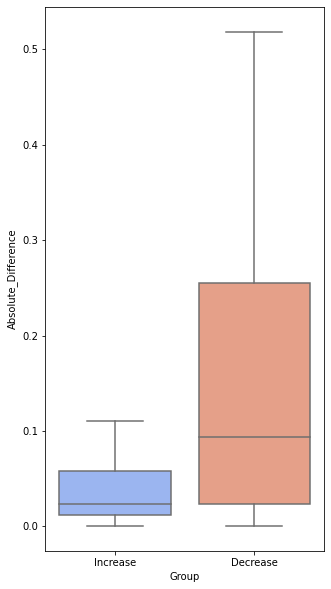

In [9]:
# Create and save boxplot of the 2 groups
rcParams['figure.figsize'] = 5,10
sns.boxplot(x="Group",
            y="Absolute_Difference",
            data=pydi_probabilities,
            order=["Increase", "Decrease"],
            palette=['#8db0fe', '#f4987a'],
            showfliers=False)
plt.savefig(fname=f"{OUTPUT_FOLDER_SUPP}/Absolute_Difference_Boxplot.svg",format='svg')
# Run rank sum test
decrease = list(pydi_probabilities[pydi_probabilities["Color_F2S"] == "#f4987a"]["Absolute_Difference"])
increase = list(pydi_probabilities[pydi_probabilities["Color_F2S"] == "#8db0fe"]["Absolute_Difference"])
comparison_ranksum = stats.ranksums(decrease, increase)
# Save result to a text file
comparison_out = open(f"{OUTPUT_FOLDER_SUPP}/Absolute_Difference_Boxplot_Statistics.txt", 'w')
comparison_out.write(f"Rank Sum Statistics: {comparison_ranksum.statistic}\nP-Value: {comparison_ranksum.pvalue}")
comparison_out.close()

### Color bar for use in Figure 2

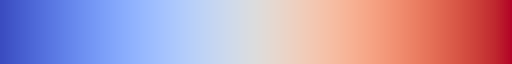

In [10]:
matplotlib.cm.get_cmap("coolwarm")

### Supplementary Figure 3C

In Figure 2B and Supplementary Figure 3A, there are 2 pairs of TFs that belong to the same structural family: 
1. ETS1 and ELK1
2. MITF and MYC

This subfigure compares the changes in the probability of forming a pyrimidine dinucleotide for both family members with a scatterplot and regression.

#### (1) Organize data to be plotted

In [15]:
# Define TFs to query for and subset relevant columns
comparison_tfs = set(["ELK1", "ETS1", "MYC", "MITF"])
comparison_df = pydi_probabilities[["First_Position", "NUV_minus_UV", "Comparison"]]
comparison_df = comparison_df[comparison_df["Comparison"].isin(comparison_tfs)].reset_index(drop=True)
# Pivot the table to wide-format for plotting
plot_df = pd.pivot(comparison_df, index="First_Position", columns="Comparison", values = "NUV_minus_UV").reset_index()
# Have a positive value indicate an increase in pyrimidine dinucleotide formation instead of a decrease
for i in ["ELK1", "ETS1", "MYC", "MITF"]:
    plot_df[i] = plot_df[i] * -1
    plot_df[i] = plot_df[i] * 100
# Display plot dataframe
plot_df

Comparison,First_Position,ELK1,ETS1,MITF,MYC
0,0,2.762709,-11.255490,-12.440979,-7.116536
1,1,-25.142806,-35.449041,62.107969,35.167365
2,2,-50.749924,-51.813712,-81.327780,-67.405876
3,3,-43.917548,-51.508945,-1.681766,-2.409431
4,4,0.826397,6.021103,-1.680481,-1.470782
5,5,1.435540,-1.042332,-0.677133,0.842602
6,6,3.488021,18.645356,-5.050161,0.622638
7,7,-26.632355,-22.978817,-5.707175,-1.113962
8,8,-46.047772,-8.550563,-81.365763,-68.331156
9,9,NaN,NaN,62.107969,35.167365


#### (2) Linear regression for each pair

In [16]:
# bHLH
res = scipy.stats.linregress(plot_df["MITF"], plot_df["MYC"])
print("bHLH:", res.rvalue ** 2)

bHLH: 0.9707187063337176


In [17]:
# ETS
res = scipy.stats.linregress(plot_df["ETS1"].dropna(), plot_df["ELK1"].dropna())
print("ETS", res.rvalue ** 2)

ETS 0.6202397439817386


#### (3) Create and save plots

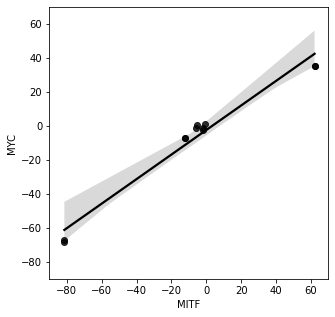

In [19]:
rcParams['figure.figsize'] = 5, 5
sns.regplot(x="MITF", y="MYC",
            data=plot_df,
            color='black')
plt.xlim(-90, 70)
plt.ylim(-90, 70)
plt.savefig(f"{OUTPUT_FOLDER_SUPP}/MITFvsMYC_Regplot.svg", format='svg')

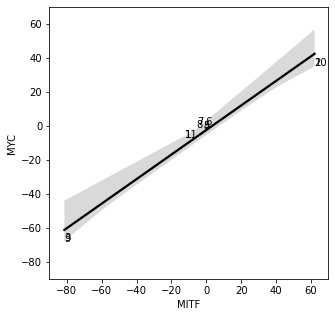

In [21]:
# For reference - plot labels
rcParams['figure.figsize'] = 5, 5
sns.regplot(x="MITF", y="MYC",
            data=plot_df,
            color='black',
            scatter=False)
for row in plot_df.itertuples():
    plt.text(row.MITF, row.MYC, row.First_Position + 1)
plt.xlim(-90, 70)
plt.ylim(-90, 70)
plt.savefig(f"{OUTPUT_FOLDER_SUPP}/MITFvsMYC_Regplot_labels.svg", format='svg')

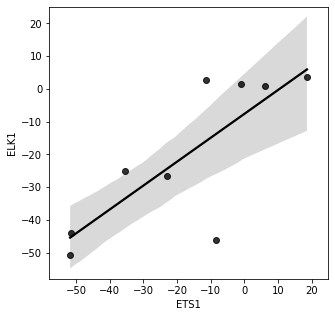

In [22]:
rcParams['figure.figsize'] = 5, 5
sns.regplot(x="ETS1",
            y="ELK1",
            color='black',
            data=plot_df)
plt.xlim(-58, 25)
plt.ylim(-58, 25)
plt.savefig(f"{OUTPUT_FOLDER_SUPP}/ETS1vELK1_Regplot.svg", format='svg')

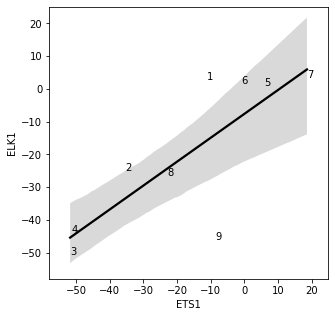

In [32]:
rcParams['figure.figsize'] = 5, 5
sns.regplot(x="ETS1",
            y="ELK1",
            color='black',
            data=plot_df,
            scatter=False)
plt.xlim(-58, 25)
plt.ylim(-58, 25)
for row in plot_df.itertuples():
    if np.isnan(row.ETS1) == False:
        plt.text(row.ETS1, row.ELK1, row.First_Position + 1)
plt.savefig(f"{OUTPUT_FOLDER_SUPP}/ETS1vELK1_Regplot_labels.svg", format='svg')